# Improved HAI-21.03 Dataset Analysis with Graph-based Features (v2)

This notebook implements an improved graph-based approach for the HAI-21.03 dataset, focusing on reducing false positives while maintaining high detection rates. The improvements include:

1. More selective feature engineering to reduce noise
2. Better threshold determination methods
3. Improved post-processing strategy to reduce false positives
4. Enhanced model architecture with regularization
5. More visualizations to understand the results

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('ggplot')
sns.set(style="darkgrid")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Import our custom data processor and improved graph features
from hai_data_processor import HAIDataProcessor
from arc1.improved_hai_graph_features import ImprovedHAIGraphFeatures

## 1. Data Loading and Processing

First, we'll load the HAI-21.03 dataset using the existing data processor.

In [2]:
# Set paths
data_dir = '../hai-security-dataset/hai-21.03'
output_dir = '../hai-security-dataset/processed'
graph_dir = '../hai-security-dataset/graph'

# Initialize data processor
processor = HAIDataProcessor(data_dir, output_dir)

# Load data
processor.load_data()

Found 3 train files and 5 test files
Loading train files: 

Loading train files:  33%|███▎      | 1/3 [00:02<00:04,  2.23s/it]

train1: 216001 rows, 84 columns


Loading train files:  67%|██████▋   | 2/3 [00:04<00:02,  2.39s/it]

train2: 226801 rows, 84 columns


Loading train files: 100%|██████████| 3/3 [00:10<00:00,  3.43s/it]


train3: 478801 rows, 84 columns
Loading test files: 

Loading test files:  20%|██        | 1/5 [00:00<00:01,  2.04it/s]

test1: 43201 rows, 84 columns


Loading test files:  40%|████      | 2/5 [00:01<00:02,  1.01it/s]

test2: 118801 rows, 84 columns


Loading test files:  60%|██████    | 3/5 [00:03<00:02,  1.11s/it]

test3: 108001 rows, 84 columns


Loading test files:  80%|████████  | 4/5 [00:03<00:00,  1.18it/s]

test4: 39601 rows, 84 columns


Loading test files: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]

test5: 92401 rows, 84 columns


## 2. Create Graph Structure

Let's create a graph structure to understand the relationships between different components.

In [3]:
# Initialize our improved graph features class
graph_features = ImprovedHAIGraphFeatures(correlation_threshold=0.7, min_anomaly_length=20, gap_threshold=3)

# Get first training dataset
train_df = list(processor.train_data.values())[0]

# Create graph from training data
G = graph_features.create_graph_from_columns(train_df)

# Print graph statistics
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Count node types safely
node_types_count = {}
for _, data in G.nodes(data=True):
    if 'type' in data:
        node_type = data['type']
        if node_type not in node_types_count:
            node_types_count[node_type] = 0
        node_types_count[node_type] += 1

print(f"\nNode types:")
for node_type, count in node_types_count.items():
    print(f"  {node_type}: {count}")

Number of nodes: 87
Number of edges: 174

Node types:
  subsystem: 4
  component: 79


Showing subgraph with 50 nodes and 140 edges


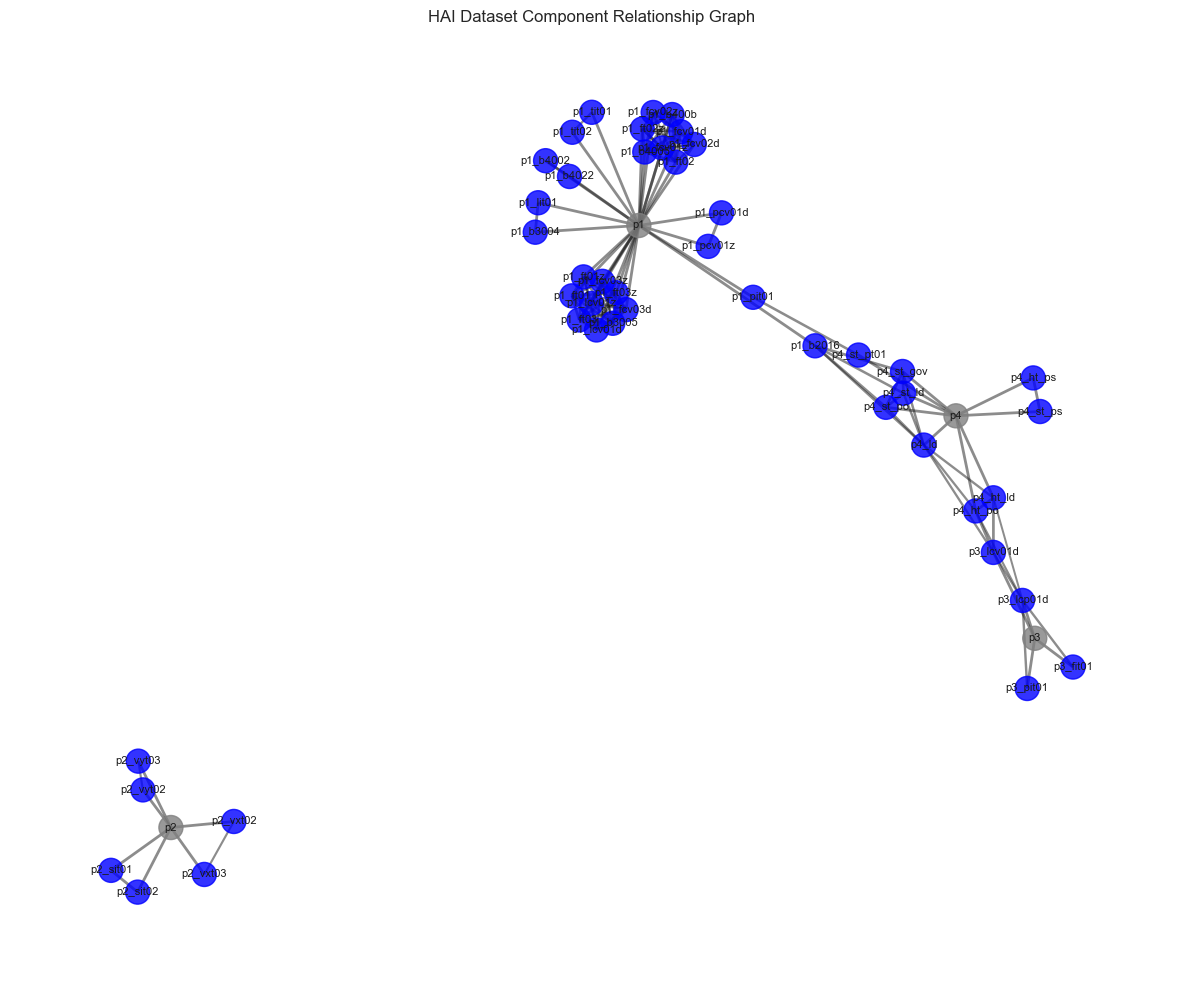

In [4]:
# Visualize the graph
def visualize_graph(G, max_nodes=50):
    """
    Visualize a graph, limiting to max_nodes if the graph is too large.
    
    Args:
        G (nx.Graph): NetworkX graph
        max_nodes (int): Maximum number of nodes to display
    """
    if G.number_of_nodes() > max_nodes:
        # Get the most connected nodes
        degrees = dict(G.degree())
        top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:max_nodes]
        G_sub = G.subgraph(top_nodes)
        print(f"Showing subgraph with {G_sub.number_of_nodes()} nodes and {G_sub.number_of_edges()} edges")
        G_vis = G_sub
    else:
        G_vis = G
    
    plt.figure(figsize=(12, 10))
    
    # Set node colors based on type (safely)
    node_colors = []
    for node in G_vis.nodes():
        node_type = G_vis.nodes[node].get('type', 'unknown')
        if node_type == 'subsystem':
            node_colors.append('red')
        elif node_type == 'component':
            node_colors.append('blue')
        else:
            node_colors.append('gray')
    
    # Set edge widths based on weight
    edge_widths = [G_vis[u][v].get('weight', 1.0) * 2 for u, v in G_vis.edges()]
    
    # Draw the graph
    pos = nx.spring_layout(G_vis, seed=42)
    nx.draw_networkx_nodes(G_vis, pos, node_color=node_colors, node_size=300, alpha=0.8)
    nx.draw_networkx_edges(G_vis, pos, width=edge_widths, alpha=0.5)
    nx.draw_networkx_labels(G_vis, pos, font_size=8)
    
    plt.title("HAI Dataset Component Relationship Graph")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize the graph
visualize_graph(G)

## 3. Analyze Graph Centrality

Let's analyze the centrality measures of the graph to better understand the relationships between components.

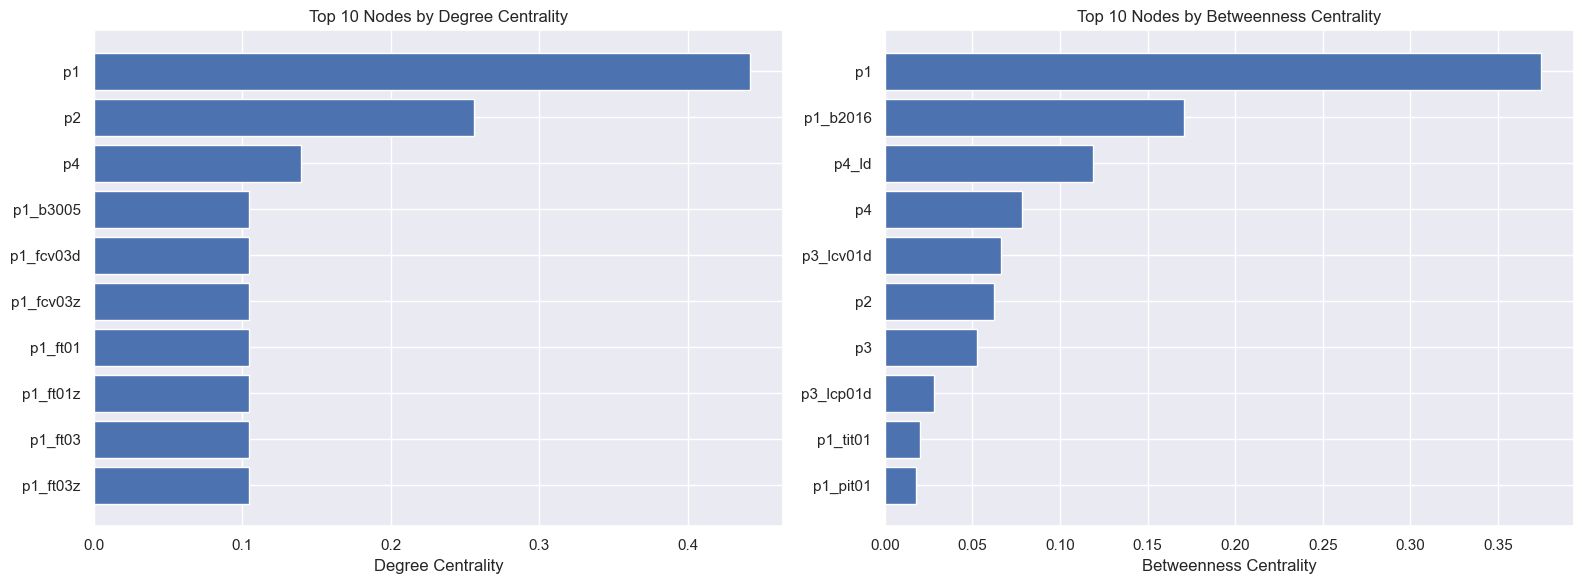

In [5]:
# Calculate centrality measures
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)

# Get top 10 nodes by degree centrality
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

# Get top 10 nodes by betweenness centrality
top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

# Plot top nodes by centrality
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot degree centrality
ax1.barh([node for node, _ in top_degree], [value for _, value in top_degree])
ax1.set_title('Top 10 Nodes by Degree Centrality')
ax1.set_xlabel('Degree Centrality')
ax1.invert_yaxis()

# Plot betweenness centrality
ax2.barh([node for node, _ in top_betweenness], [value for _, value in top_betweenness])
ax2.set_title('Top 10 Nodes by Betweenness Centrality')
ax2.set_xlabel('Betweenness Centrality')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

## 4. Graph-based Feature Engineering

Let's use the graph structure to create more meaningful features with our improved feature engineering approach.

In [6]:
# Apply improved graph-based feature engineering
train_df_processed = graph_features.graph_based_feature_engineering(train_df, G, include_centrality=True, include_communities=False)

# Process test data
test_df = list(processor.test_data.values())[0]
test_df_processed = graph_features.graph_based_feature_engineering(test_df, G, include_centrality=True, include_communities=False)

# Print feature counts
print(f"Original train features: {train_df.shape[1]}")
print(f"Processed train features: {train_df_processed.shape[1]}")
print(f"New features added: {train_df_processed.shape[1] - train_df.shape[1]}")

Original train features: 84
Processed train features: 84
New features added: 0


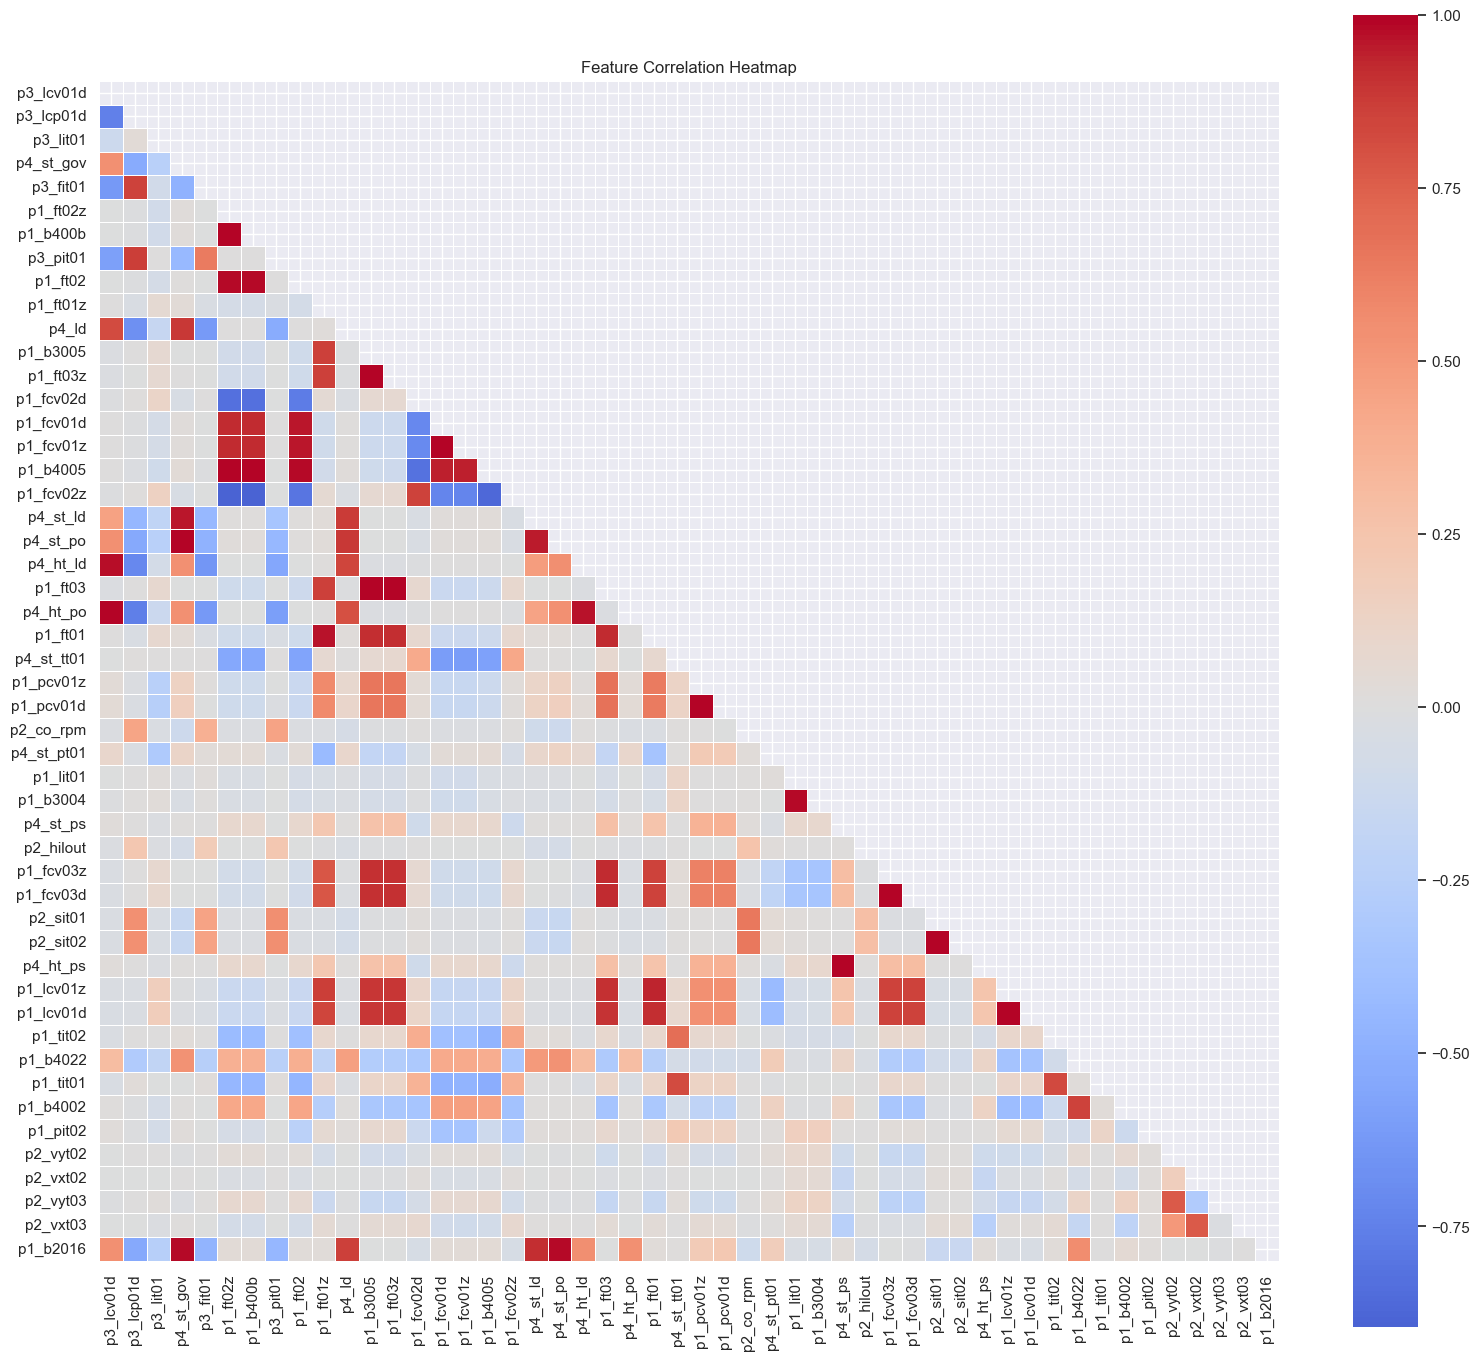

In [7]:
# Visualize feature correlations
def plot_feature_correlation_heatmap(df, max_features=50):
    """
    Plot a correlation heatmap for the top features.
    
    Args:
        df (pd.DataFrame): DataFrame with features
        max_features (int): Maximum number of features to display
    """
    # Exclude non-numeric and target columns
    exclude_cols = ['time', 'attack', 'attack_P1', 'attack_P2', 'attack_P3']
    feature_cols = [col for col in df.columns if col not in exclude_cols and 
                    pd.api.types.is_numeric_dtype(df[col])]
    
    # If too many features, select a subset
    if len(feature_cols) > max_features:
        # Calculate variance for each feature
        variances = df[feature_cols].var()
        top_features = variances.nlargest(max_features).index.tolist()
    else:
        top_features = feature_cols
    
    # Calculate correlation matrix
    corr_matrix = df[top_features].corr()
    
    # Plot heatmap
    plt.figure(figsize=(16, 14))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', center=0, 
                square=True, linewidths=0.5, annot=False, fmt='.2f')
    plt.title('Feature Correlation Heatmap')
    plt.tight_layout()
    plt.show()

# Plot correlation heatmap
plot_feature_correlation_heatmap(train_df_processed)

## 5. Feature Selection and Dimensionality Reduction

Let's select the most relevant features and reduce dimensionality using our improved methods.

In [8]:
# Select features and reduce dimensions
X_train_pca, X_test_pca, y_test, scaler, pca, selected_features = graph_features.select_features_and_reduce_dimensions(
    train_df_processed, test_df_processed, n_components=40, feature_selection_method='isolation_forest'
)

Explained variance ratio: 1.0000
Selected 82 features out of 82


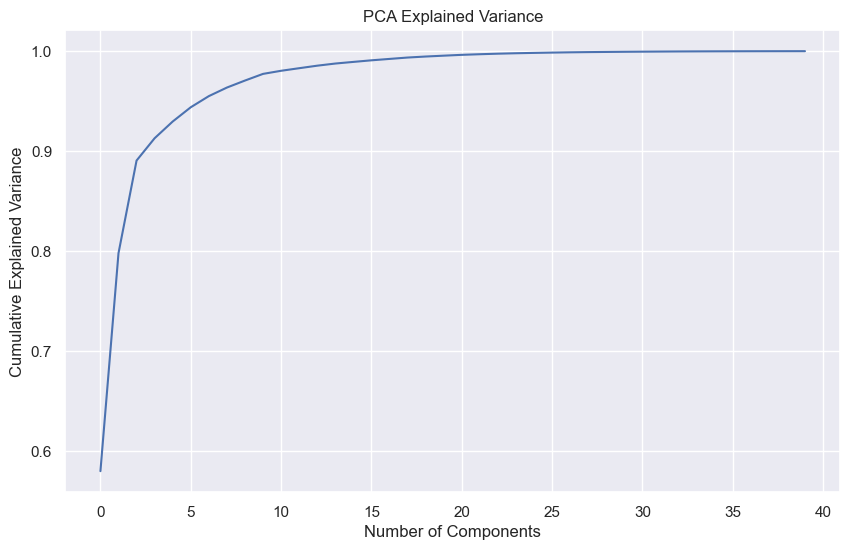

In [9]:
# Visualize PCA components
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

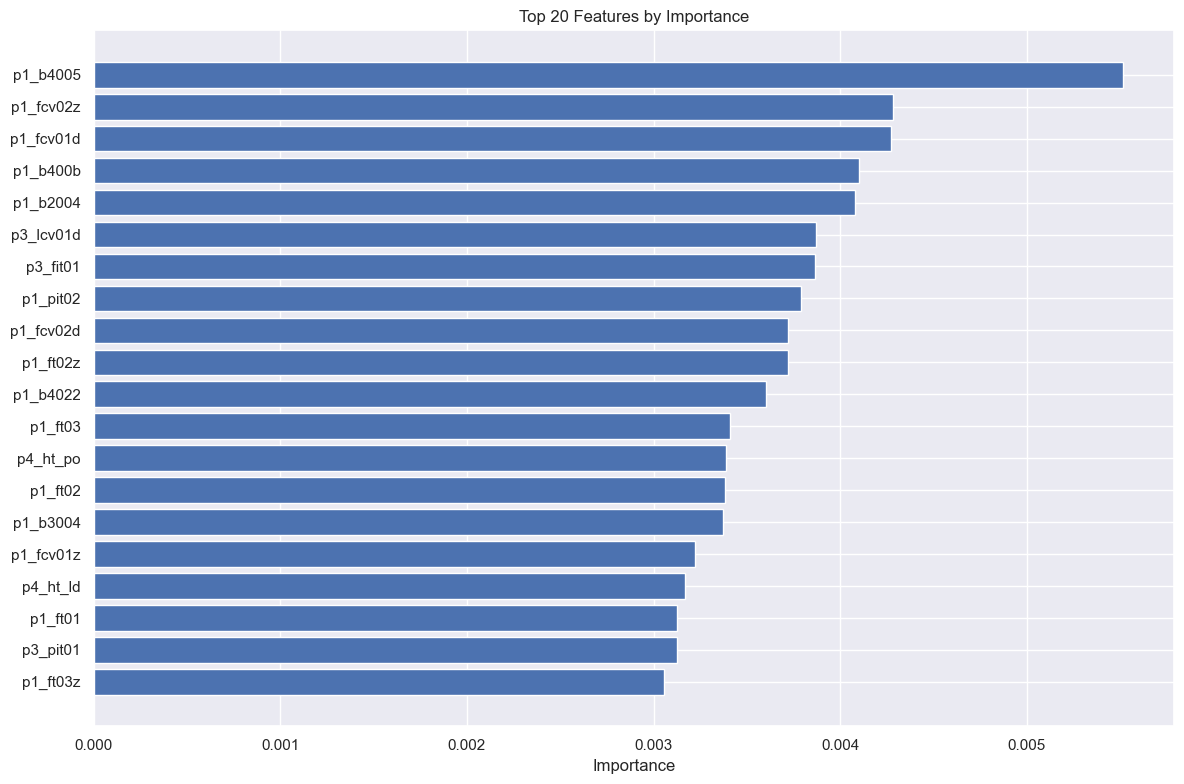

In [10]:
# Visualize feature importance
if hasattr(graph_features, 'feature_importance') and graph_features.feature_importance is not None:
    # Get top 20 features by importance
    top_features = sorted(graph_features.feature_importance.items(), key=lambda x: x[1], reverse=True)[:20]
    
    plt.figure(figsize=(12, 8))
    plt.barh([feature for feature, _ in top_features], [importance for _, importance in top_features])
    plt.xlabel('Importance')
    plt.title('Top 20 Features by Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

## 6. Time Series Preprocessing

Let's create sequences for time series modeling.

In [11]:
# Create sequences for time series models
seq_length = 50
stride = 10

X_train_seq = graph_features.create_sequences(X_train_pca, seq_length, stride)
X_test_seq = graph_features.create_sequences(X_test_pca, seq_length, stride)

print("Training sequences shape:", X_train_seq.shape)
print("Test sequences shape:", X_test_seq.shape)

Training sequences shape: (21596, 50, 40)
Test sequences shape: (4316, 50, 40)


## 7. Improved LSTM Autoencoder Model

Let's build an improved bidirectional LSTM autoencoder model for anomaly detection.

In [12]:
# Build improved LSTM autoencoder
print("Building improved LSTM Autoencoder model...")

# Build model
lstm_autoencoder = graph_features.build_improved_lstm_autoencoder(seq_length, X_train_pca.shape[1])

# Print model summary
lstm_autoencoder.summary()

Building improved LSTM Autoencoder model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 50, 128)        │        53,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 50, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 64)             │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 50, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 50, 64)         │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 50, 64)         │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 50, 128)        │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_3           │ (None, 50, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 50, 40)         │         5,160 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185,176 (723.34 KB)

 Trainable params: 185,176 (723.34 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Train model
print("Training LSTM Autoencoder model...")

# Set model in graph_features
graph_features.model = lstm_autoencoder

# Train model
history = graph_features.train_model(
    X_train_seq,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    patience=15
)

Training LSTM Autoencoder model...
Epoch 1/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 35s 85ms/step - loss: 4.0184 - val_loss: 1.7991 - learning_rate: 0.0010
Epoch 2/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - loss: 1.6256 - val_loss: 1.4159 - learning_rate: 0.0010
Epoch 3/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - loss: 1.4711 - val_loss: 1.3865 - learning_rate: 0.0010
Epoch 4/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 27s 100ms/step - loss: 1.4277 - val_loss: 1.3725 - learning_rate: 0.0010
Epoch 5/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 29s 107ms/step - loss: 1.3911 - val_loss: 1.3811 - learning_rate: 0.0010
Epoch 6/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 29s 107ms/step - loss: 1.3746 - val_loss: 1.3705 - learning_rate: 0.0010
Epoch 7/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 26s 95ms/step - loss: 1.3642 - val_loss: 1.3604 - learning_rate: 0.0010
Epoch 8/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 25s 91ms/step - loss: 1.3571 - val_loss: 1.3541 - learning_rate: 0.0010
Epoch 9/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 28s 102ms/step - 

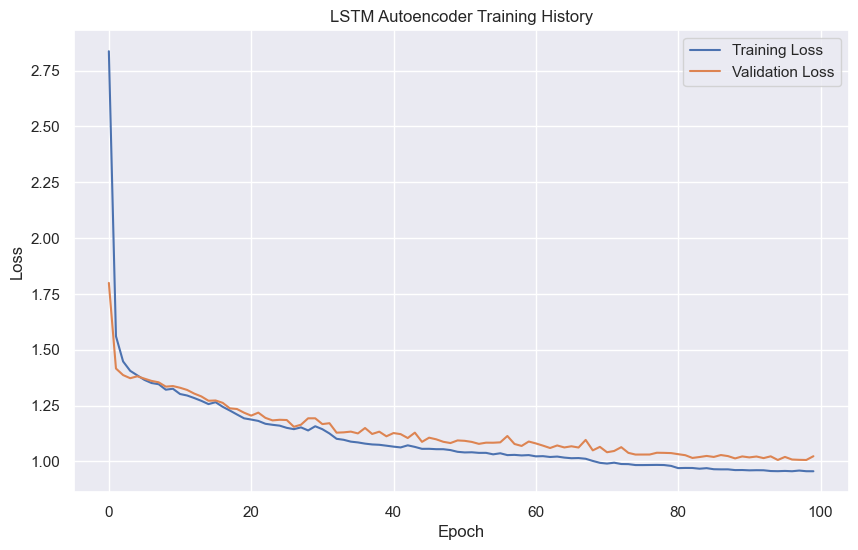

In [14]:
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Autoencoder Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## 8. Anomaly Detection with Improved Threshold Determination

Let's detect anomalies using the trained model with improved threshold determination.

In [15]:
# Determine threshold using dynamic method
threshold = graph_features.determine_threshold(X_train_seq, method='dynamic', contamination=0.01)
print(f"Dynamic threshold: {threshold:.6f}")

# Also calculate IQR threshold for comparison
iqr_threshold = graph_features.determine_threshold(X_train_seq, method='iqr')
print(f"IQR-based threshold: {iqr_threshold:.6f}")

# Also calculate percentile threshold for comparison
percentile_threshold = graph_features.determine_threshold(X_train_seq, method='percentile')
print(f"Percentile-based threshold: {percentile_threshold:.6f}")

675/675 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step
Dynamic threshold: 3.353141
675/675 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step
IQR-based threshold: 2.164091
675/675 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step
Percentile-based threshold: 3.345501


In [16]:
# Predict on test data
X_test_pred = lstm_autoencoder.predict(X_test_seq)

# Calculate reconstruction error
mse = np.mean(np.square(X_test_seq - X_test_pred), axis=(1, 2))

# Detect anomalies with improved post-processing
anomaly_scores, y_pred = graph_features.detect_anomalies_with_improved_postprocessing(
    mse, threshold, seq_length, stride, len(y_test)
)

135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


## 9. Evaluation with eTaPR

Let's evaluate the model using eTaPR metrics.

In [17]:
# Import eTaPR
try:
    from eTaPR_pkg import etapr
    from eTaPR_pkg.DataManage import Range
    
    # Convert to ranges for eTaPR evaluation
    def convert_to_ranges(predictions):
        """
        Convert binary predictions to ranges for eTaPR evaluation.
        
        Args:
            predictions (np.array): Binary predictions
            
        Returns:
            list: List of Range objects
        """
        ranges = []
        in_anomaly = False
        start_idx = 0
        
        for i, pred in enumerate(predictions):
            if pred == 1 and not in_anomaly:
                # Start of anomaly
                in_anomaly = True
                start_idx = i
            elif pred == 0 and in_anomaly:
                # End of anomaly
                in_anomaly = False
                ranges.append(Range.Range(start_idx, i-1, ''))
        
        # Handle case where last point is anomaly
        if in_anomaly:
            ranges.append(Range.Range(start_idx, len(predictions)-1, ''))
        
        return ranges

    # Convert ground truth and predictions to ranges
    y_true_ranges = convert_to_ranges(y_test)
    y_pred_ranges = convert_to_ranges(y_pred)

    print(f"Number of ground truth ranges: {len(y_true_ranges)}")
    print(f"Number of predicted ranges: {len(y_pred_ranges)}")

    # If either is empty, create a dummy range to avoid errors
    if len(y_true_ranges) == 0:
        print("Warning: No ground truth ranges found. Creating a dummy range.")
        y_true_ranges = [Range.Range(0, 1, '')]
        
    if len(y_pred_ranges) == 0:
        print("Warning: No predicted ranges found. Creating a dummy range.")
        y_pred_ranges = [Range.Range(0, 1, '')]
        
    # Evaluate with eTaPR
    def evaluate_with_etapr(model_name, y_true_ranges, y_pred_ranges):
        """
        Evaluate predictions using eTaPR.
        
        Args:
            model_name (str): Name of the model
            y_true_ranges (list): Ground truth ranges
            y_pred_ranges (list): Predicted ranges
            
        Returns:
            dict: eTaPR results
        """
        # Set eTaPR parameters
        theta_p = 0.5
        theta_r = 0.1
        delta = 0.0
        
        try:
            # Evaluate using eTaPR
            result = etapr.evaluate_w_ranges(y_true_ranges, y_pred_ranges, theta_p=theta_p, theta_r=theta_r, delta=delta)
            
            # Print results
            print(f"Model: {model_name}")
            print(f"eTaP: {result['eTaP']:.6f}\t\teTaR: {result['eTaR']:.6f}")
            print(f"precision: {result['precision']:.6f}\trecall: {result['recall']:.6f}")
            print(f"point-adjust precision: {result['point_adjust_precision']:.6f}\tpoint-adjust recall: {result['point_adjust_recall']:.6f}")
            
            # Calculate F1 score
            if result['eTaP'] + result['eTaR'] > 0:
                f1 = 2 * (result['eTaP'] * result['eTaR']) / (result['eTaP'] + result['eTaR'])
            else:
                f1 = 0.0
            print(f"F1 score: {f1:.6f}")
            
            return result
        except Exception as e:
            print(f"Error evaluating with eTaPR: {e}")
            return None

    # Evaluate model
    result = evaluate_with_etapr("Improved Graph-based LSTM Autoencoder", y_true_ranges, y_pred_ranges)
    
    # Visualize results
    try:
        # Visualize with eTaPR
        etapr.draw_graph(y_true_ranges, y_pred_ranges, 'screen')
    except Exception as e:
        print(f"Error visualizing results: {e}")
        
except ImportError:
    print("eTaPR package not installed. Install with: pip install eTaPR")
    
    # Calculate standard metrics without eTaPR
    from sklearn.metrics import precision_score, recall_score, f1_score
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Precision: {precision:.6f}")
    print(f"Recall: {recall:.6f}")
    print(f"F1 Score: {f1:.6f}")
    
    # Create a dummy result for later use
    result = {
        'eTaP': precision,
        'eTaR': recall,
        'precision': precision,
        'recall': recall,
        'point_adjust_precision': precision,
        'point_adjust_recall': recall
    }

Number of ground truth ranges: 5
Number of predicted ranges: 49
Model: Improved Graph-based LSTM Autoencoder
eTaP: 0.157116		eTaR: 0.862546
precision: 0.244444	recall: 0.699523
point-adjust precision: 0.316239	point-adjust recall: 1.000000
F1 score: 0.265814


## 10. Visualize Results

Let's visualize the anomaly detection results.

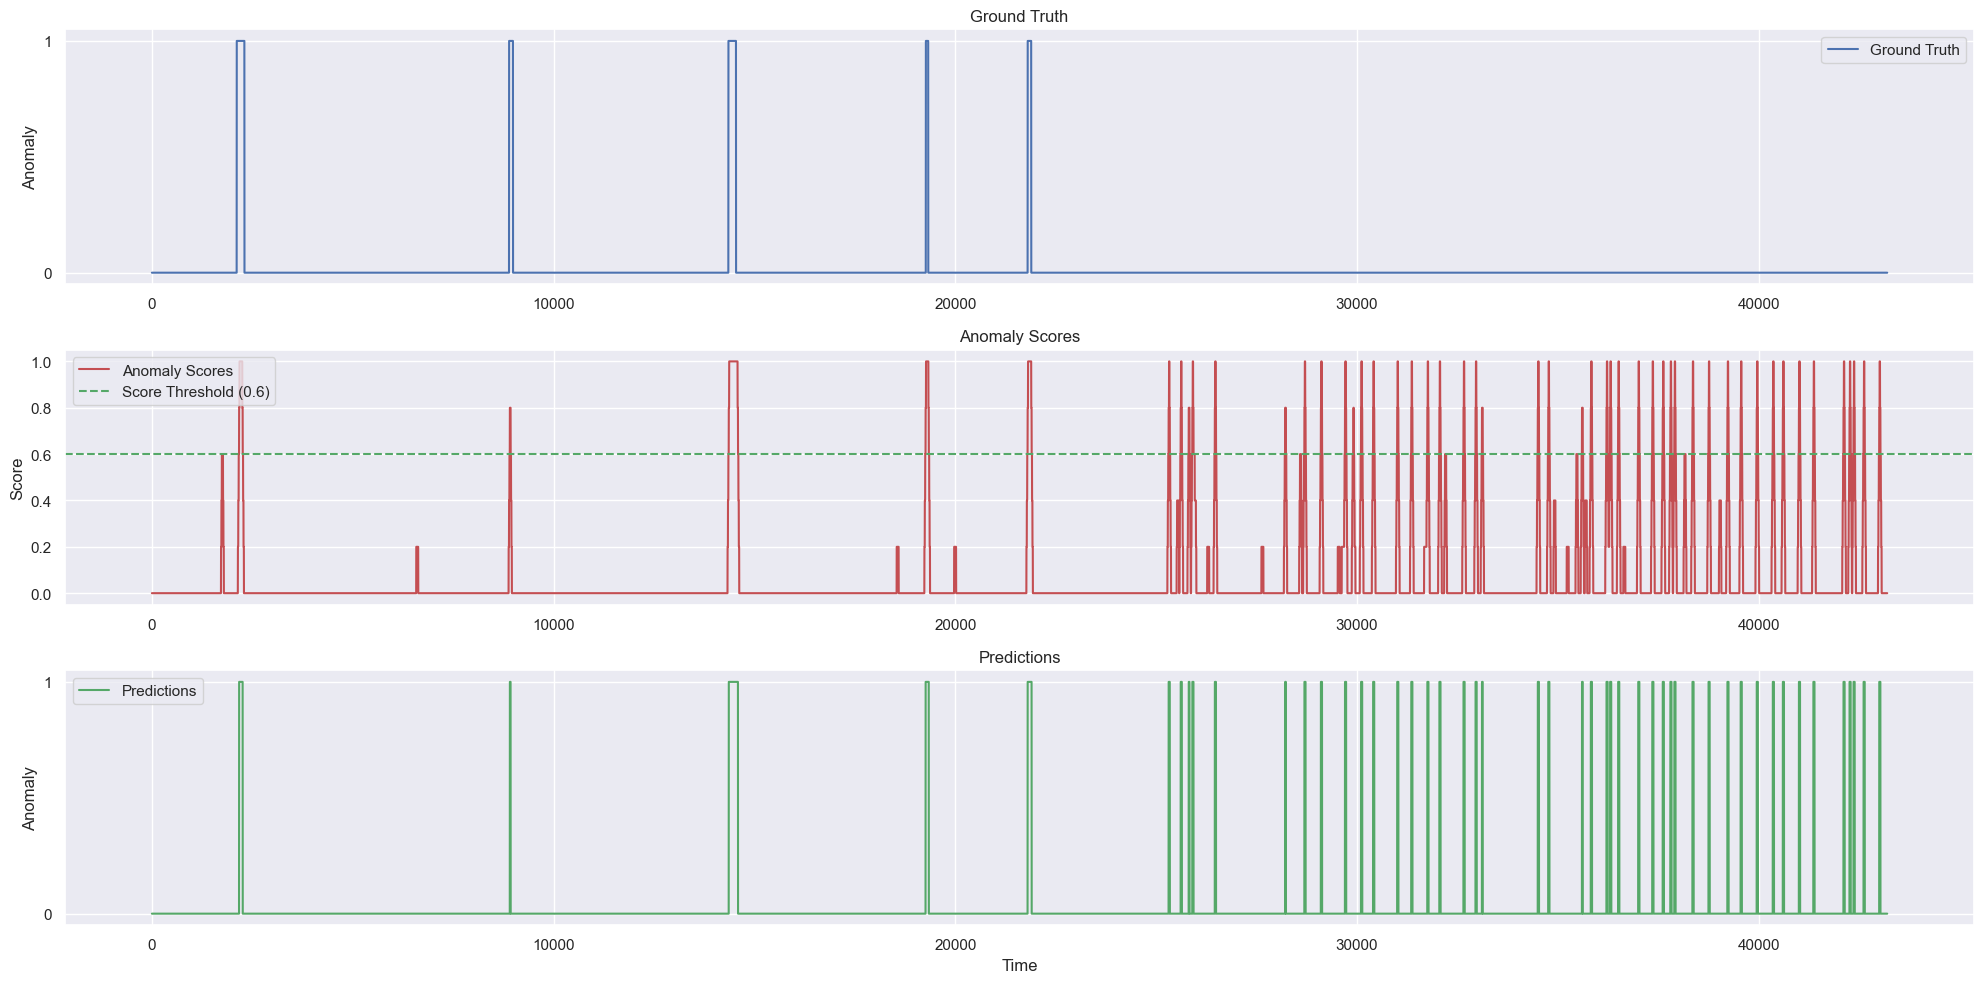

In [18]:
# Visualize anomaly scores and predictions
plt.figure(figsize=(20, 10))

# Plot ground truth
plt.subplot(3, 1, 1)
plt.plot(y_test, 'b-', label='Ground Truth')
plt.title('Ground Truth')
plt.ylabel('Anomaly')
plt.yticks([0, 1])
plt.grid(True)
plt.legend()

# Plot anomaly scores
plt.subplot(3, 1, 2)
plt.plot(anomaly_scores, 'r-', label='Anomaly Scores')
plt.axhline(y=0.6, color='g', linestyle='--', label='Score Threshold (0.6)')
plt.title('Anomaly Scores')
plt.ylabel('Score')
plt.grid(True)
plt.legend()

# Plot predictions
plt.subplot(3, 1, 3)
plt.plot(y_pred, 'g-', label='Predictions')
plt.title('Predictions')
plt.xlabel('Time')
plt.ylabel('Anomaly')
plt.yticks([0, 1])
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

675/675 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step


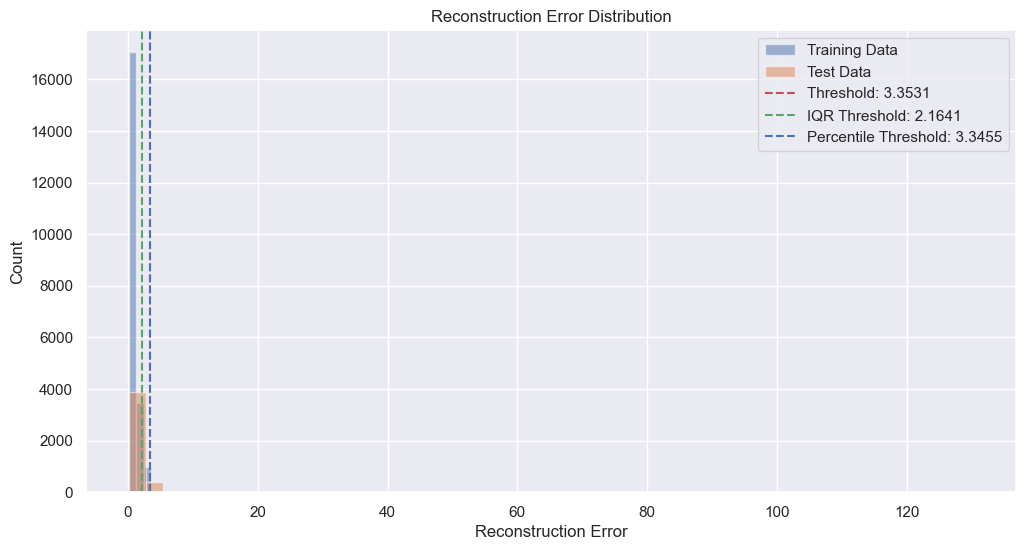

In [19]:
# Visualize reconstruction error distribution
plt.figure(figsize=(12, 6))

# Get reconstruction errors for train and test data
X_train_pred = lstm_autoencoder.predict(X_train_seq)
train_mse = np.mean(np.square(X_train_seq - X_train_pred), axis=(1, 2))

# Plot histograms
plt.hist(train_mse, bins=50, alpha=0.5, label='Training Data')
plt.hist(mse, bins=50, alpha=0.5, label='Test Data')
plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.4f}')
plt.axvline(x=iqr_threshold, color='g', linestyle='--', label=f'IQR Threshold: {iqr_threshold:.4f}')
plt.axvline(x=percentile_threshold, color='b', linestyle='--', label=f'Percentile Threshold: {percentile_threshold:.4f}')
plt.xlabel('Reconstruction Error')
plt.ylabel('Count')
plt.title('Reconstruction Error Distribution')
plt.legend()
plt.grid(True)
plt.show()

## 11. Compare with Previous Models

Let's compare the improved graph-based LSTM autoencoder with previous models.

In [20]:
# Compare models
models = [
    ('Isolation Forest', 0.000000, 0.000000, 0.015101, 0.014308, 0.000000, 0.000000),
    ('LSTM Autoencoder', 0.075407, 0.589583, 0.119693, 0.744038, 0.122387, 0.763116),
    ('Bidirectional LSTM', 0.082332, 0.586979, 0.137261, 0.729730, 0.142645, 0.763116),
    ('Balanced CNN-LSTM', 0.030966, 0.400000, 0.010210, 0.236884, 0.010210, 0.236884),
    ('Graph-based LSTM', 0.213861, 0.841446, 0.021024, 0.620032, 0.033477, 1.000000)
]

# Add improved graph-based LSTM results if available
if result is not None:
    improved_graph_lstm_results = (
        'Improved Graph-based LSTM',
        result['eTaP'],
        result['eTaR'],
        result['precision'],
        result['recall'],
        result['point_adjust_precision'],
        result['point_adjust_recall']
    )
    models.append(improved_graph_lstm_results)

# Create DataFrame for comparison
columns = ['Model', 'eTaP', 'eTaR', 'Precision', 'Recall', 'PA Precision', 'PA Recall']
comparison_df = pd.DataFrame(models, columns=columns)

# Calculate F1 scores
comparison_df['F1 (eTaPR)'] = 2 * (comparison_df['eTaP'] * comparison_df['eTaR']) / (comparison_df['eTaP'] + comparison_df['eTaR'] + 1e-10)
comparison_df['F1 (Standard)'] = 2 * (comparison_df['Precision'] * comparison_df['Recall']) / (comparison_df['Precision'] + comparison_df['Recall'] + 1e-10)
comparison_df['F1 (PA)'] = 2 * (comparison_df['PA Precision'] * comparison_df['PA Recall']) / (comparison_df['PA Precision'] + comparison_df['PA Recall'] + 1e-10)

# Replace NaN with 0
comparison_df = comparison_df.fillna(0)

# Display comparison
comparison_df

,Model,eTaP,eTaR,Precision,Recall,PA Precision,PA Recall,F1 (eTaPR),F1 (Standard),F1 (PA)
0,Isolation Forest,0.000000,0.000000,0.015101,0.014308,0.000000,0.000000,0.000000,0.014694,0.000000
1,LSTM Autoencoder,0.075407,0.589583,0.119693,0.744038,0.122387,0.763116,0.133712,0.206213,0.210943
2,Bidirectional LSTM,0.082332,0.586979,0.137261,0.729730,0.142645,0.763116,0.144409,0.231060,0.240361
3,Balanced CNN-LSTM,0.030966,0.400000,0.010210,0.236884,0.010210,0.236884,0.057482,0.019576,0.019576
4,Graph-based LSTM,0.213861,0.841446,0.021024,0.620032,0.033477,1.000000,0.341043,0.040669,0.064785
5,Improved Graph-based LSTM,0.157116,0.862546,0.244444,0.699523,0.316239,1.000000,0.265814,0.362289,0.480519


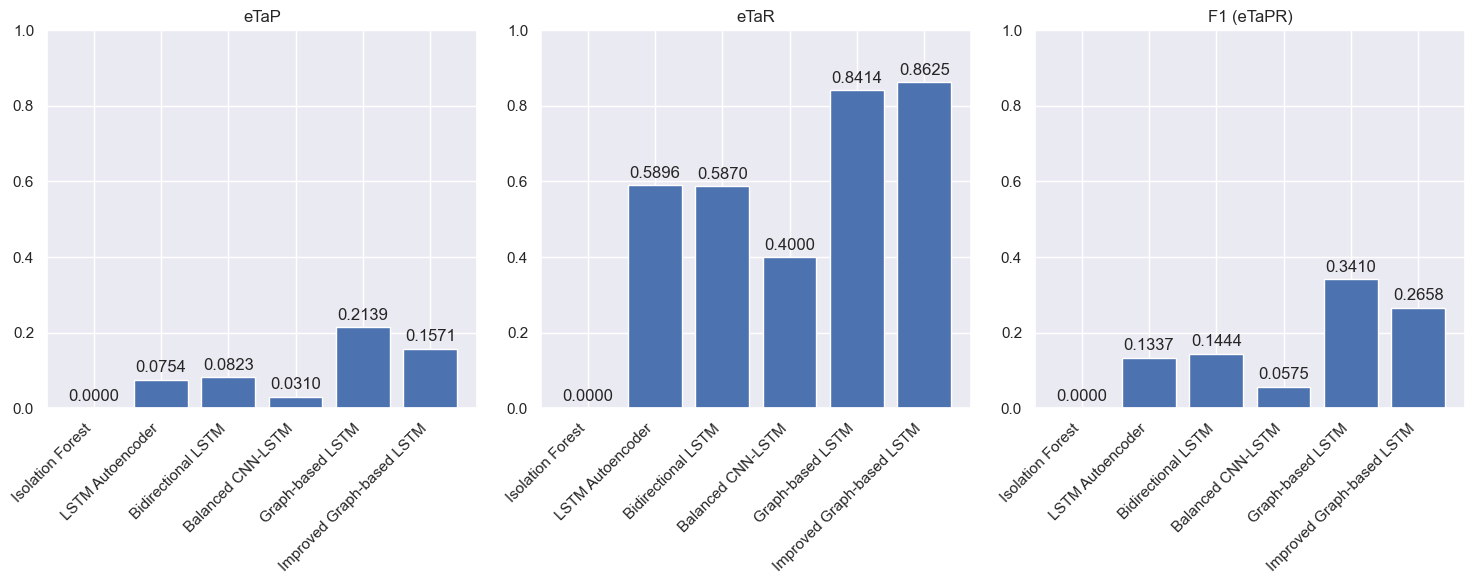

In [21]:
# Visualize comparison
metrics = ['eTaP', 'eTaR', 'F1 (eTaPR)']
plt.figure(figsize=(15, 6))

for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i+1)
    plt.bar(comparison_df['Model'], comparison_df[metric])
    plt.title(metric)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)
    
    # Add value labels
    for j, v in enumerate(comparison_df[metric]):
        plt.text(j, v + 0.02, f"{v:.4f}", ha='center')

plt.tight_layout()
plt.show()

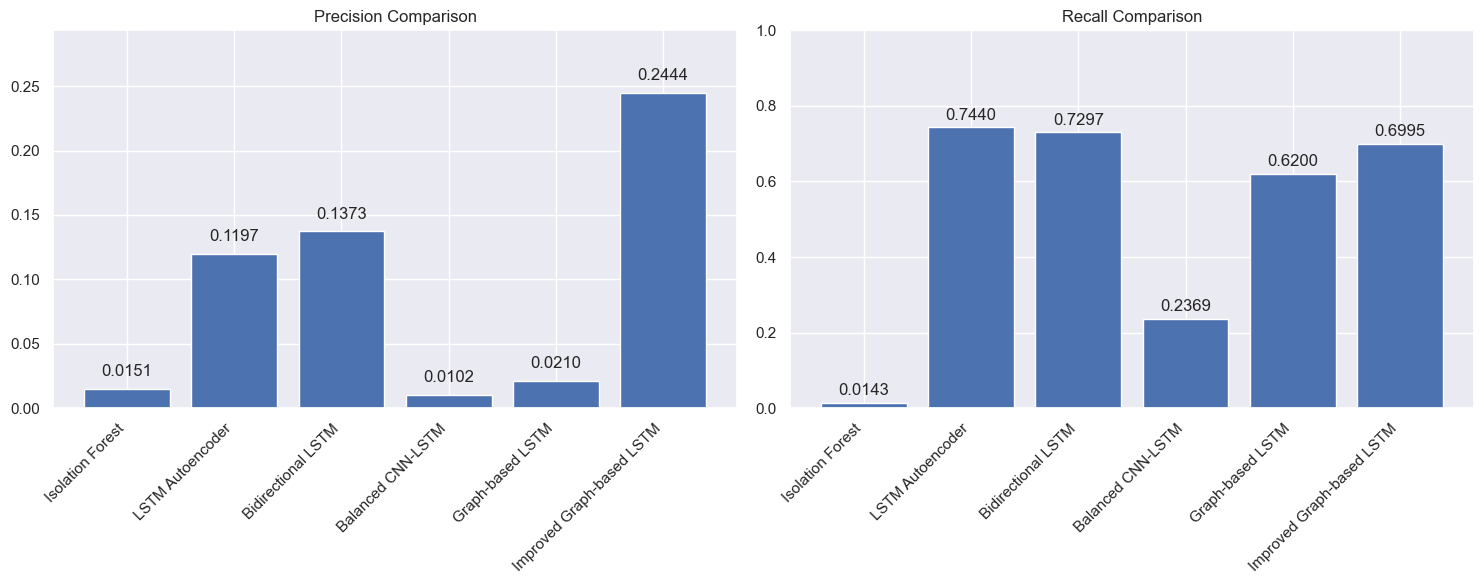

In [22]:
# Visualize precision-recall comparison
plt.figure(figsize=(15, 6))

# Plot precision comparison
plt.subplot(1, 2, 1)
plt.bar(comparison_df['Model'], comparison_df['Precision'])
plt.title('Precision Comparison')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, max(comparison_df['Precision']) * 1.2)
for j, v in enumerate(comparison_df['Precision']):
    plt.text(j, v + 0.01, f"{v:.4f}", ha='center')

# Plot recall comparison
plt.subplot(1, 2, 2)
plt.bar(comparison_df['Model'], comparison_df['Recall'])
plt.title('Recall Comparison')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
for j, v in enumerate(comparison_df['Recall']):
    plt.text(j, v + 0.02, f"{v:.4f}", ha='center')

plt.tight_layout()
plt.show()

## 12. Analyze False Positives and False Negatives

Let's analyze the false positives and false negatives to better understand the model's performance.

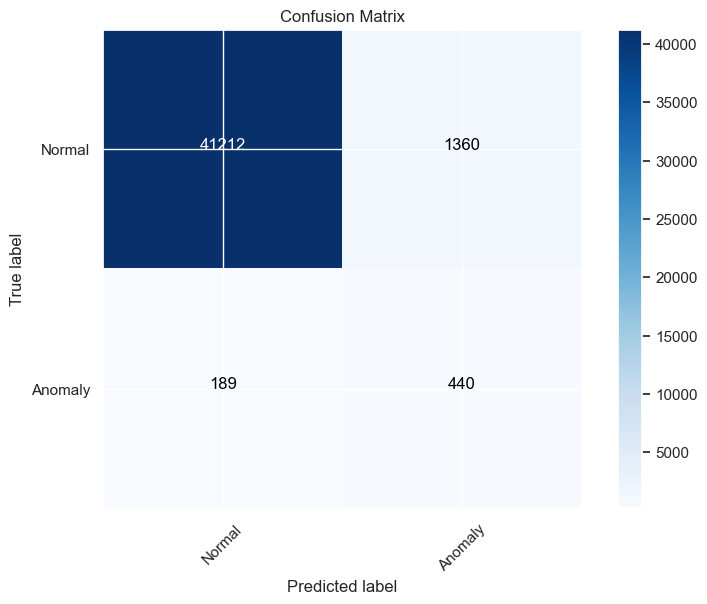

Accuracy: 0.9641
Precision: 0.2444
Recall: 0.6995
F1 Score: 0.3623
False Positive Rate: 0.0319
False Negative Rate: 0.3005


In [23]:
# Calculate confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = [0, 1]
plt.xticks(tick_marks, ['Normal', 'Anomaly'], rotation=45)
plt.yticks(tick_marks, ['Normal', 'Anomaly'])

# Add text annotations
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Calculate metrics
tn, fp, fn, tp = cm.ravel()
total = tn + fp + fn + tp
accuracy = (tp + tn) / total
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
false_negative_rate = fn / (fn + tp) if (fn + tp) > 0 else 0

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"False Positive Rate: {false_positive_rate:.4f}")
print(f"False Negative Rate: {false_negative_rate:.4f}")

Number of false positive regions: 49
Number of false negative regions: 5


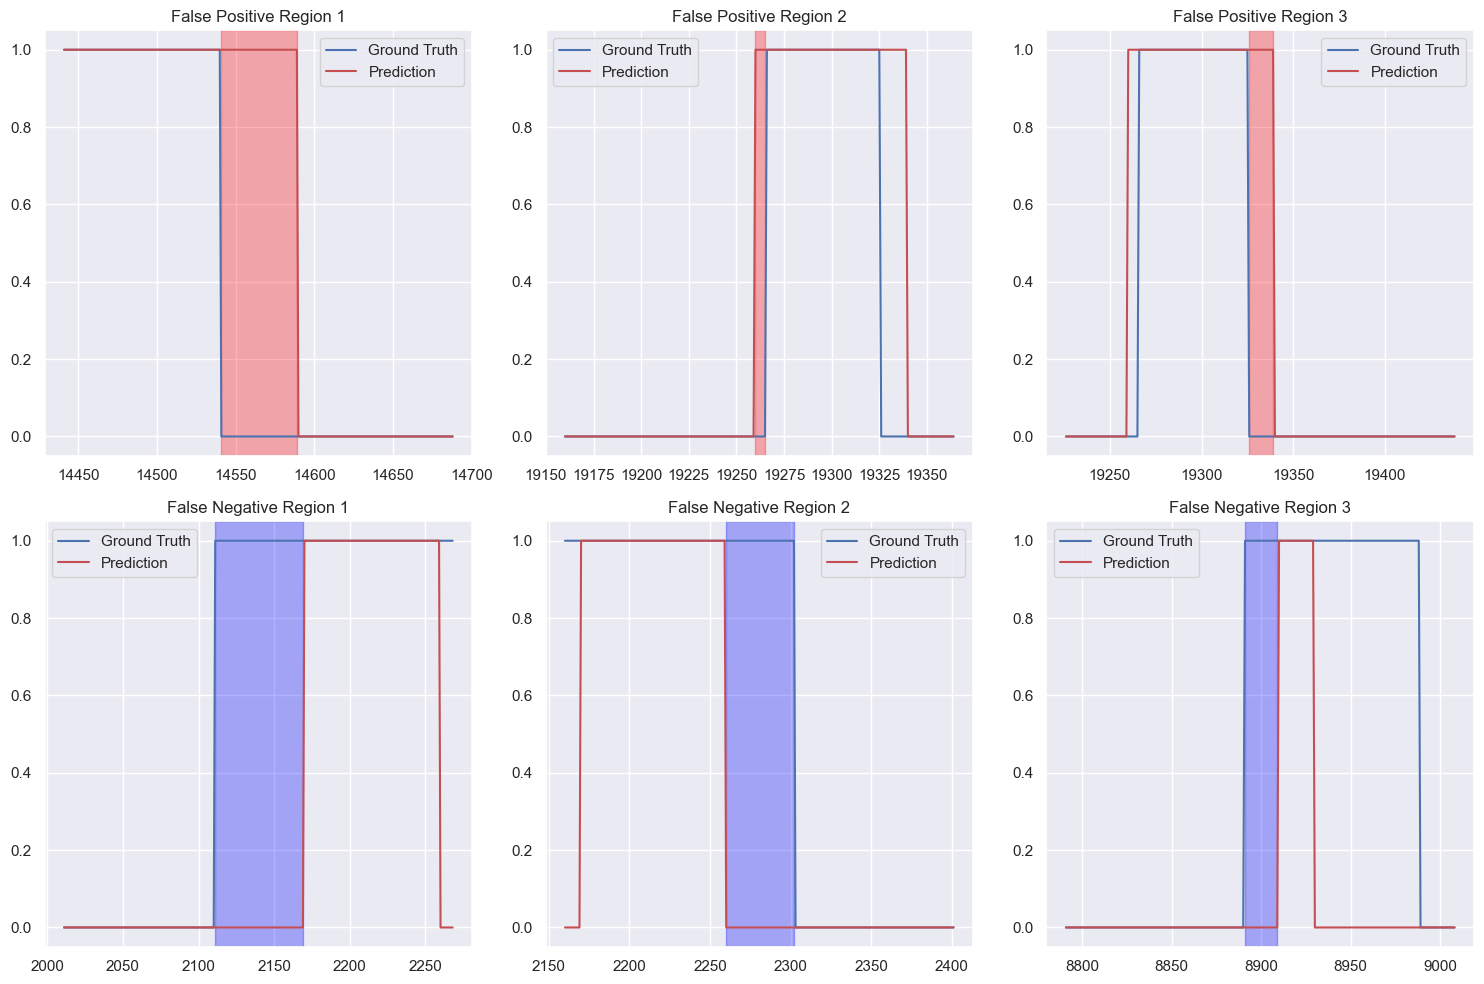

In [24]:
# Find false positive and false negative regions
false_positives = np.where((y_pred == 1) & (y_test == 0))[0]
false_negatives = np.where((y_pred == 0) & (y_test == 1))[0]

# Group consecutive indices into regions
def group_consecutive(indices):
    regions = []
    for k, g in itertools.groupby(enumerate(indices), lambda ix: ix[0] - ix[1]):
        region = list(map(lambda x: x[1], g))
        regions.append((region[0], region[-1]))
    return regions

fp_regions = group_consecutive(false_positives)
fn_regions = group_consecutive(false_negatives)

print(f"Number of false positive regions: {len(fp_regions)}")
print(f"Number of false negative regions: {len(fn_regions)}")

# Plot a few examples of false positives and false negatives
if len(fp_regions) > 0 or len(fn_regions) > 0:
    plt.figure(figsize=(15, 10))
    
    # Plot false positives
    if len(fp_regions) > 0:
        num_fp_to_show = min(3, len(fp_regions))
        for i in range(num_fp_to_show):
            start, end = fp_regions[i]
            # Add some context around the region
            context = 100
            plot_start = max(0, start - context)
            plot_end = min(len(y_test), end + context)
            
            plt.subplot(2, num_fp_to_show, i+1)
            plt.plot(range(plot_start, plot_end), y_test[plot_start:plot_end], 'b-', label='Ground Truth')
            plt.plot(range(plot_start, plot_end), y_pred[plot_start:plot_end], 'r-', label='Prediction')
            plt.axvspan(start, end, alpha=0.3, color='red')
            plt.title(f'False Positive Region {i+1}')
            plt.legend()
    
    # Plot false negatives
    if len(fn_regions) > 0:
        num_fn_to_show = min(3, len(fn_regions))
        for i in range(num_fn_to_show):
            start, end = fn_regions[i]
            # Add some context around the region
            context = 100
            plot_start = max(0, start - context)
            plot_end = min(len(y_test), end + context)
            
            plt.subplot(2, num_fn_to_show, num_fn_to_show + i+1)
            plt.plot(range(plot_start, plot_end), y_test[plot_start:plot_end], 'b-', label='Ground Truth')
            plt.plot(range(plot_start, plot_end), y_pred[plot_start:plot_end], 'r-', label='Prediction')
            plt.axvspan(start, end, alpha=0.3, color='blue')
            plt.title(f'False Negative Region {i+1}')
            plt.legend()
    
    plt.tight_layout()
    plt.show()